# Prep

In [53]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import eval_hermitenorm
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder


%matplotlib inline

In [161]:
nonlinears = [lambda x: np.log(np.abs(x) + 0.1),
              np.exp, np.square, np.sin, np.cos,
              lambda x: np.sqrt(np.abs(x)), 
              lambda x: x]


def make_data(n, p, k, eps, spurious_intercept=False, linear=True):
    tmp = np.random.rand(n, p)
    tmp = tmp - np.mean(tmp, axis=0, keepdims=True)
    
    if isinstance(k, list):
        xs = []
        for kk in k:
            x = np.random.choice(kk, n).reshape(-1, 1)
            enc = OneHotEncoder(handle_unknown='ignore')
            xs.append(enc.fit_transform(x).toarray()[:, :])
        x = np.concatenate([tmp] + xs, axis=1)
    elif k > 0:
        x = np.random.choice(k, n).reshape(-1, 1)
        enc = OneHotEncoder(handle_unknown='ignore')
        x = enc.fit_transform(x).toarray()[:, :]
        x = np.concatenate([tmp, x], axis=1)
    else:
        x = tmp
    
    y = np.zeros(n)

    params = []
    for i in range(x.shape[1]):
        slope = 10*(np.random.random() - 0.5)
        if linear:
            params.append(slope)
            y += slope * x[:, i]
        else:
            i_nl = np.random.choice(len(nonlinears))
            params.append([slope, i_nl])
            y += slope * nonlinears[i_nl](x[:, i])

    y += eps * np.random.randn(n)

    if spurious_intercept:
        x = np.concatenate([x, np.ones((n, 1))], axis=1)

    return params, x, y

# Data + Model

In [162]:
n = 20
n_train = 15
p = 1
k = 0
intercept = True
linear = True
params, x, y = make_data(n, p, k, 3, spurious_intercept=intercept, linear=linear)

# x = np.concatenate([x, np.ones((n, 1))], axis=1)
x_n = copy.copy(x)
x_n[:, :p] = (x[:, :p] - np.mean(x[:, :p], 0))
x_n[:, :p] /= np.std(x[:, :p], 0)

# tmp = eval_hermitenorm(2, x_n[:, :p])
# x_n = np.concatenate([x_n, (tmp - np.mean(tmp, 0))/np.std(tmp, 0)], axis=1)

y_n = y
y_n = (y - np.mean(y))/np.std(y)

In [163]:
alpha = 5e-3
model = Ridge(alpha=alpha, fit_intercept=False).fit(x_n[:n_train], y_n[:n_train] )

In [164]:
if not linear:
    slopes, fnc = list(zip(*params))
    print(fnc)
else:
    slopes = params

coef = np.array(slopes) / np.std(y)
coef[:p] *= np.std(x[:, :p], 0)
print(coef)
print(model.coef_)

print(np.mean(np.abs(coef - model.coef_[:len(coef)])))
    
print(np.mean(np.abs(y_n[n_train:] - model.predict(x_n[n_train:]))))

[0.33456863]
[ 0.49347336 -0.21579192]
0.15890472502488107
0.8954592032185896


In [622]:
x_n[:3], y_n[:3]

(array([[-0.61078912,  1.45262108, -1.60212297,  1.        ,  0.        ,
          0.        , -0.76043441,  1.28700968,  1.56496291],
        [ 0.30484024,  0.28812975,  1.07721577,  0.        ,  1.        ,
          0.        , -1.10022134, -1.06310714,  0.16020595],
        [ 1.47343018, -0.48842874,  0.52230394,  1.        ,  0.        ,
          0.        ,  1.42034451, -0.88277651, -0.72634687]]),
 array([ 1.04593314, -0.28913959,  0.74767026]))

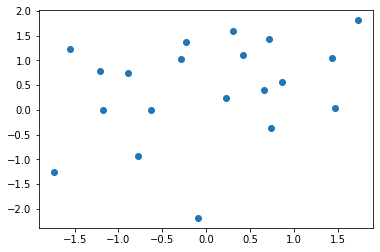

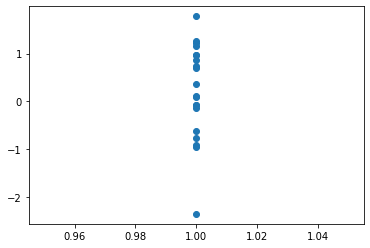

In [165]:
for i in range(x_n.shape[1]):
    plt.figure()
    other = model.coef_[-1] + np.sum([model.coef_[j]*x_n[:, j] for j in range(x_n.shape[1]) if i!=j], axis=0)
    plt.plot(x_n[:, i], y_n - other, 'o')

# Statistics vs alpha

In [782]:
# n = 15
# n_train = 10
p = 3
k = 3
intercept = True
linear = True

# maps_f = []
map_n = []
for n_train in [4, 6, 8, 10, 15, 50, 100, 250, 500, 1000]:
    n = int(1.5*n_train)
    maps = []
    for _ in range(500):
        params, x, y = make_data(n, p, k, 0.3, spurious_intercept=intercept, linear=linear)
        x_n = copy.copy(x)
        x_n[:, :p] = (x[:, :p] - np.mean(x[:, :p], 0))
        x_n[:, :p] /= np.std(x[:, :p], 0)

        tmp = eval_hermitenorm(2, x_n[:, :p])
        x_n = np.concatenate([x_n, (tmp - np.mean(tmp, 0))/np.std(tmp, 0)], axis=1)
        y_n = (y - np.mean(y))/np.std(y)
        if not linear:
            slopes, fnc = list(zip(*params))
    #         print(fnc)
        else:
            slopes = params
        coef = np.array(slopes)/np.std(y)
        coef[:p] *= np.std(x[:, :p], 0)

        map_a = []
        for alpha in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1]:
            model = Ridge(alpha=alpha, fit_intercept=False).fit(x_n[:n_train], y_n[:n_train])
            map_a.append(np.mean(np.abs(y_n[n_train:] - model.predict(x_n[n_train:]))))
        maps.append(map_a)
    maps = np.array(maps)
    
    map_n.append(np.column_stack([np.min(maps, axis=0),
                                  np.mean(maps, axis=0),
                                  np.max(maps, axis=0)]))
#     maps.append(np.mean(np.abs(coef - model.coef_[:-1])))
    
#     model = Ridge(alpha=alpha, fit_intercept=False).fit(x_n[:, :-1], y_n)
#     maps_f.append(np.mean(np.abs(coef - model.coef_)))
#     maps_f.append(np.mean(np.abs(y_n - model.predict(x_n[:, :-1]))))
maps_n_linear = np.array(map_n)

In [780]:
maps_n = np.array(map_n)

In [785]:
with np.printoptions(precision=3, suppress=True):
    print(maps_n_linear)

[[[ 0.067  0.662  1.784]
  [ 0.067  0.662  1.784]
  [ 0.067  0.662  1.784]
  [ 0.065  0.662  1.784]
  [ 0.03   0.661  1.778]
  [ 0.047  0.666  1.755]
  [ 0.046  0.673  1.733]]

 [[ 0.024  0.461  1.636]
  [ 0.024  0.461  1.636]
  [ 0.024  0.461  1.636]
  [ 0.022  0.461  1.641]
  [ 0.023  0.474  1.663]
  [ 0.057  0.514  1.668]
  [ 0.073  0.544  1.659]]

 [[ 0.005  0.262 15.735]
  [ 0.005  0.226  3.979]
  [ 0.005  0.213  1.214]
  [ 0.005  0.216  1.206]
  [ 0.015  0.259  1.192]
  [ 0.022  0.337  1.195]
  [ 0.037  0.389  1.187]]

 [[ 0.006  0.085  2.946]
  [ 0.006  0.081  2.382]
  [ 0.006  0.071  1.575]
  [ 0.006  0.068  0.945]
  [ 0.011  0.125  1.159]
  [ 0.022  0.225  1.127]
  [ 0.042  0.282  1.071]]

 [[ 0.004  0.029  0.375]
  [ 0.004  0.029  0.375]
  [ 0.004  0.029  0.375]
  [ 0.005  0.03   0.372]
  [ 0.007  0.045  0.344]
  [ 0.02   0.11   0.528]
  [ 0.032  0.162  0.639]]

 [[ 0.006  0.015  0.064]
  [ 0.006  0.015  0.064]
  [ 0.006  0.015  0.064]
  [ 0.006  0.015  0.064]
  [ 0.006  0.01

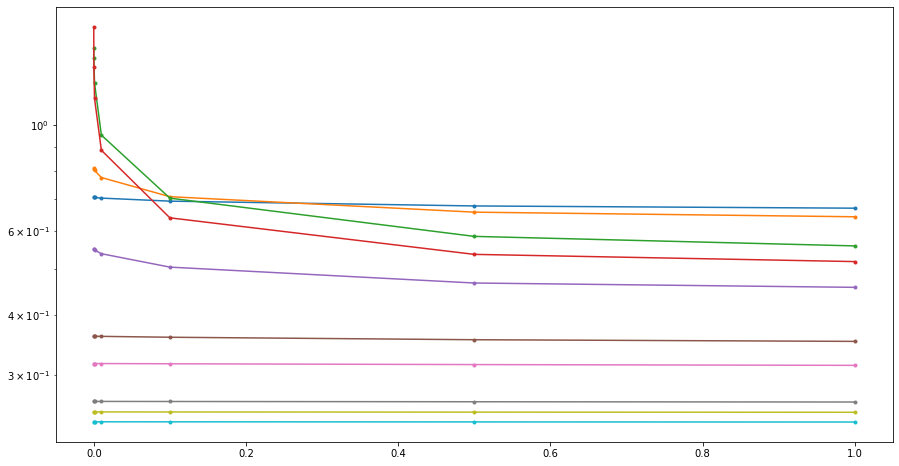

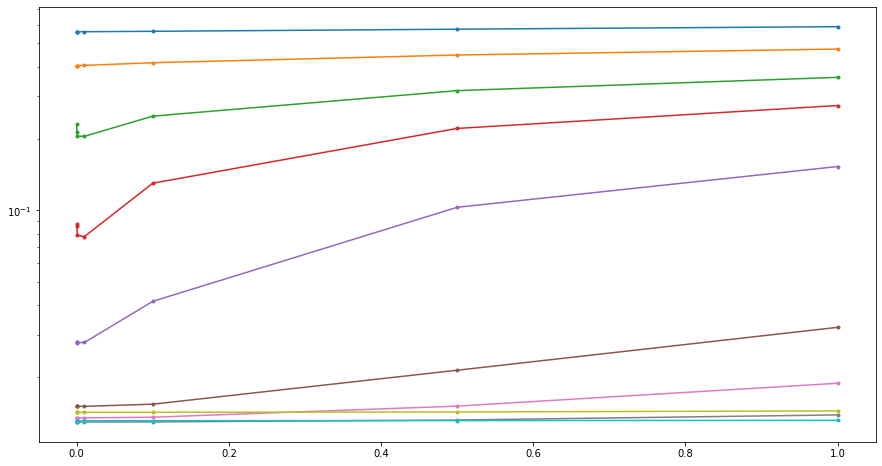

In [781]:
plt.figure(figsize=(15,8))
plt.plot([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1], maps_n[:, :, 1].transpose(), '.-')
plt.yscale('log');

plt.figure(figsize=(15,8))
plt.plot([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1], maps_n_linear[:, :, 1].transpose(), '.-')
plt.yscale('log');

In [765]:
with np.printoptions(precision=3, suppress=True):
    print([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1])
    print(np.min(maps, axis=0))
    print(np.mean(maps, axis=0))
    print(np.max(maps, axis=0))

[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5, 1]
[0.004 0.004 0.004 0.005 0.014 0.036 0.047]
[1.542 1.409 1.107 0.792 0.566 0.485 0.472]
[56.033 46.9   17.864  5.68   2.459  1.803  1.556]


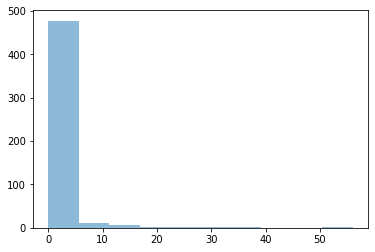

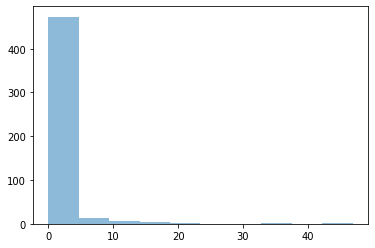

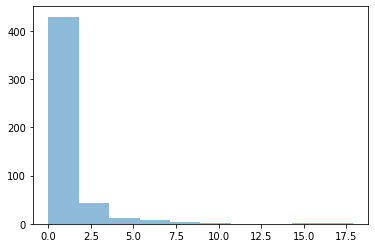

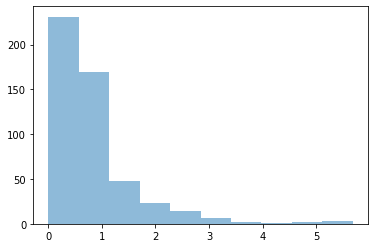

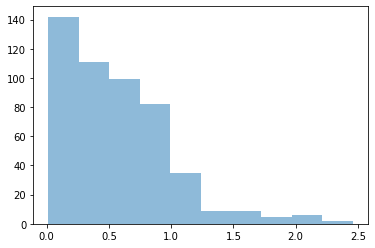

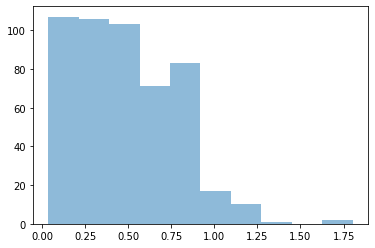

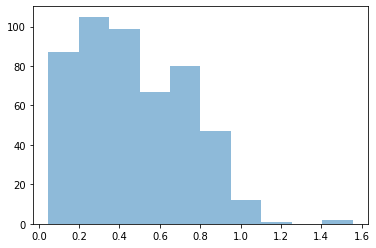

In [766]:
for map_a in maps.transpose():
    plt.figure()
    plt.hist(map_a, alpha=0.5)
# plt.hist(maps_f, alpha=0.5)

# Uncertainty

In [166]:
xn_alpha = np.concatenate([x_n[:n_train], np.sqrt(alpha)*np.eye(x_n.shape[1])], axis=0)
yn_alpha = np.concatenate([y_n[:n_train], np.zeros(x_n.shape[1])], axis=0)

In [167]:
q, r = np.linalg.qr(xn_alpha)
inv_r = np.linalg.inv(r)

coef = np.matmul(inv_r, np.matmul(q.transpose(), yn_alpha))
sigma = np.sqrt(np.sum(np.square(y_n[:n_train] - np.matmul(x_n[:n_train], model.coef_)))/(n_train - p))

In [179]:
# verify 
np.allclose(np.matmul(q.transpose(), q), np.eye(x_n.shape[1]))

True

In [180]:
# verify
np.allclose(coef, model.coef_)

True

In [172]:
samples = 10000
coefs = np.zeros((len(coef), samples))
for i in range(samples):
    coefs[:, i] = coef + sigma*np.matmul(inv_r, np.random.standard_t(n_train - len(coef), len(coef)))

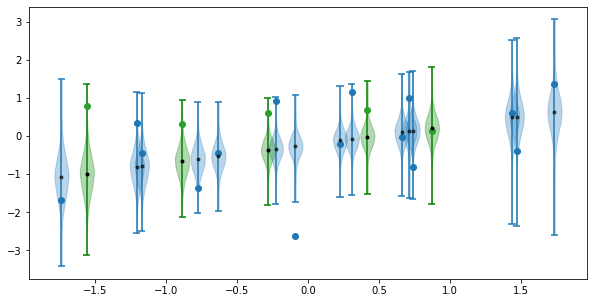

In [173]:
plt.figure(figsize=(10,5))

plt.plot(x_n[:n_train, 0], y_n[:n_train], 'o')
plt.plot(x_n[:n_train, 0], np.matmul(x_n[:n_train], model.coef_), '.k', alpha=0.6)
violin_parts = plt.violinplot(np.matmul(x_n[:n_train], coefs).transpose(), x_n[:n_train, 0], widths=0.1)
c = 'tab:blue'
for vv in violin_parts['bodies']:
    vv.set_color(c)
violin_parts['cbars'].set_color(c)
violin_parts['cmins'].set_color(c)
violin_parts['cmaxes'].set_color(c)
# plt.plot(x_n[:n_train, 0], np.matmul(x_n[:n_train], coefs), '.g', alpha=0.01);

plt.plot(x_n[n_train:, 0], y_n[n_train:], 'o')
plt.plot(x_n[n_train:, 0], np.matmul(x_n[n_train:], model.coef_), '.k')
violin_parts = plt.violinplot(np.matmul(x_n[n_train:], coefs).transpose(), x_n[n_train:, 0], widths=0.1)
c = 'green'
for vv in violin_parts['bodies']:
    vv.set_color(c)
violin_parts['cbars'].set_color(c)
violin_parts['cmins'].set_color(c)
violin_parts['cmaxes'].set_color(c)
plt.savefig('rl_error.png')
# plt.plot(x_n[n_train:, 0], np.matmul(x_n[n_train:], coefs), '.', alpha=0.01);